## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'pastis-full' 
TRANSFORM = 'wavelet-diagonal'
CHANNEL = 'green'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
green_diagonal_wavelet_full_pastis.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/pastis/full/wavelet/diagonal/green'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 1590, 3: 6360, 4: 25440, 5: 101760, 6: 407040, 7: 1628160, 8: 6512640}

Running 12760 CDFs


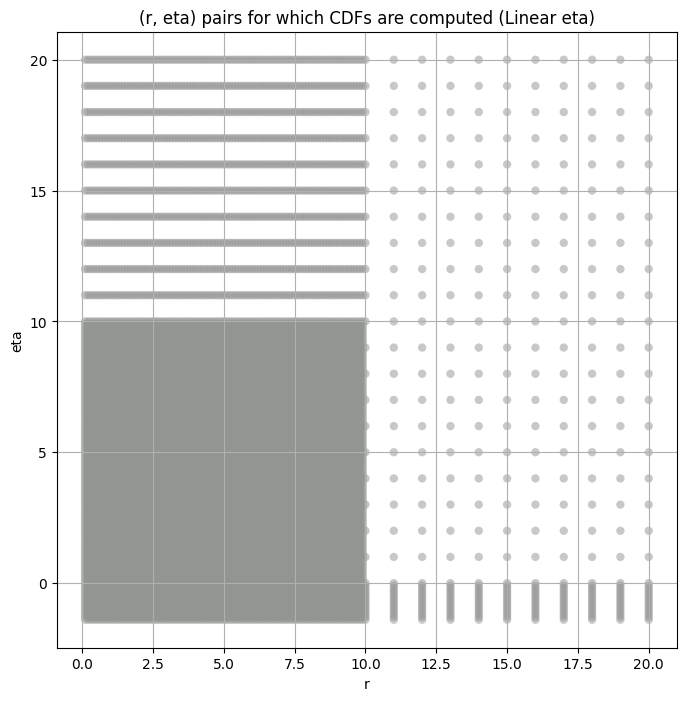

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var   var_lower    var_upper   obs_kurt  kurt_lower  kurt_upper  \
layer                                                                           
2      990.116330  861.928960  1131.759600   2.443838    1.024734    4.018030   
3      301.279600  280.958000   322.557980   2.566934    1.891120    3.315567   
4       75.477356   71.196570    79.962980   3.069100    2.393951    4.079803   
5       14.740032   13.840556    15.680383   3.907264    3.033695    5.042107   
6        2.678430    2.496106     2.874468   5.563306    4.164392    8.168119   
7        0.470237    0.432168     0.512633   8.734539    6.109381   15.380407   
8        0.052278    0.047054     0.060721  21.203135    7.482663  102.776710   

       total_samples  
layer                 
2               1590  
3               6360  
4              25440  
5             101760  
6             407040  
7            1628160  
8            6512640

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                              
2      990.116330     990.116333      715.236206      591.125000   
3      301.279600     301.279602      262.677734      242.003036   
4       75.477356      75.477356       71.727135       69.193527   
5       14.740032      14.740032       14.436079       14.225165   
6        2.678430       2.678430        2.608754        2.563191   
7        0.470237       0.470237        0.453764        0.443636   
8        0.052278       0.052278        0.049372        0.048031   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2          502.190704       431.443176       330.154541       256.451080   
3          226.728500       213.564453       192.020920       174.188690   
4           67.082069        65.278366        62.285427        59.765835   
5           14.044789        13.882556        13.597095        13.349264   
6            2.525105         2.491393         2.431999         2.380068   
7            0.435284         0.428008         0.415422         0.404630   
8            0.046964         0.046051         0.044510         0.043213   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2           198.467148       152.141266       114.776825        45.848000  
3           159.402603       146.531662       135.161346       107.857582  
4            57.557419        55.545753        53.696842        48.925522  
5            13.124011        12.914814        12.720017        12.198795  
6             2.333270         2.290627         2.251379         2.147758  
7             0.395072         0.386415         0.378485         0.357708  
8             0.042080         0.041066         0.040146         0.037781

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.012203412403293812 990.11633


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.024807874655071727 715.2362


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.039293244169009305 591.125


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.0555651230385642 502.1907


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.07372242496093961 431.44318


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.10452705020010022 330.15454


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.1312416770418594 256.45108


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.1543854116702137 198.46715


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.1782321006255817 152.14127


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.20051158612342956 114.776825


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.2758611736496646 45.848
Number of samples: 1590, Without approximation : 1590


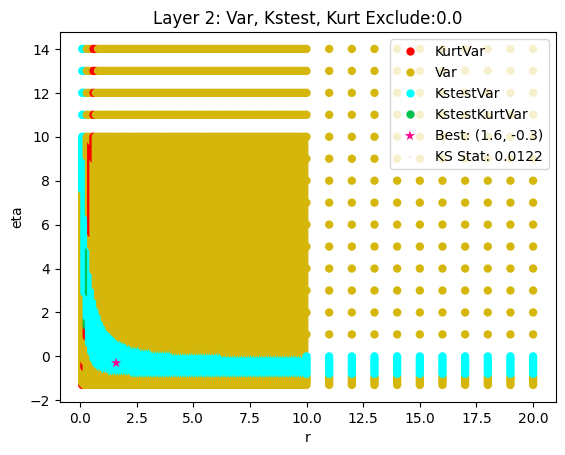

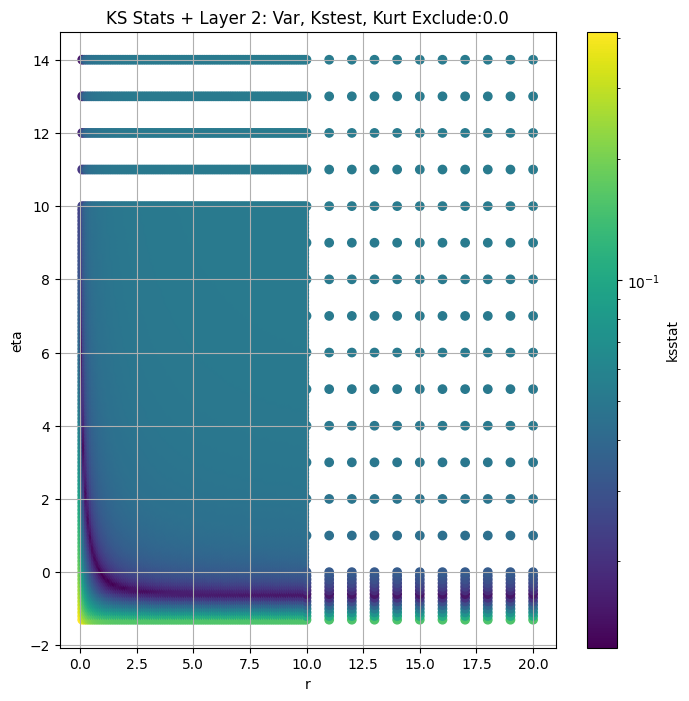

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.007931352457062446 301.2796


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.009597620870516632 262.67773


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.013795743674800964 242.00304


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.0188261911215353 226.7285


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.023960050901494376 213.56445


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.033114713344912255 192.02092


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.04130899223311768 174.18869


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.048928513813196274 159.4026


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.05612070111939653 146.53166


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.06342273333018747 135.16135


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.08397353579074547 107.85758
Number of samples: 6360, Without approximation : 6360


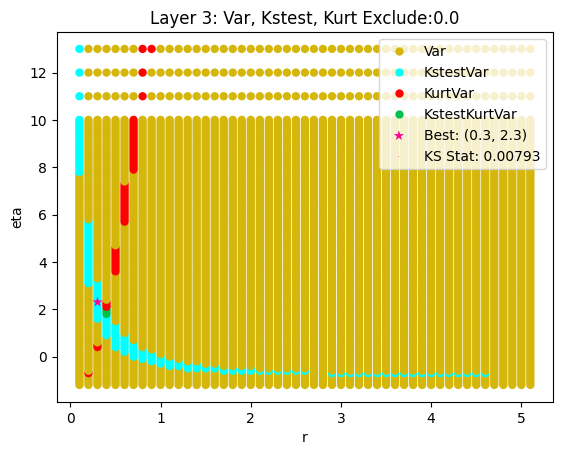

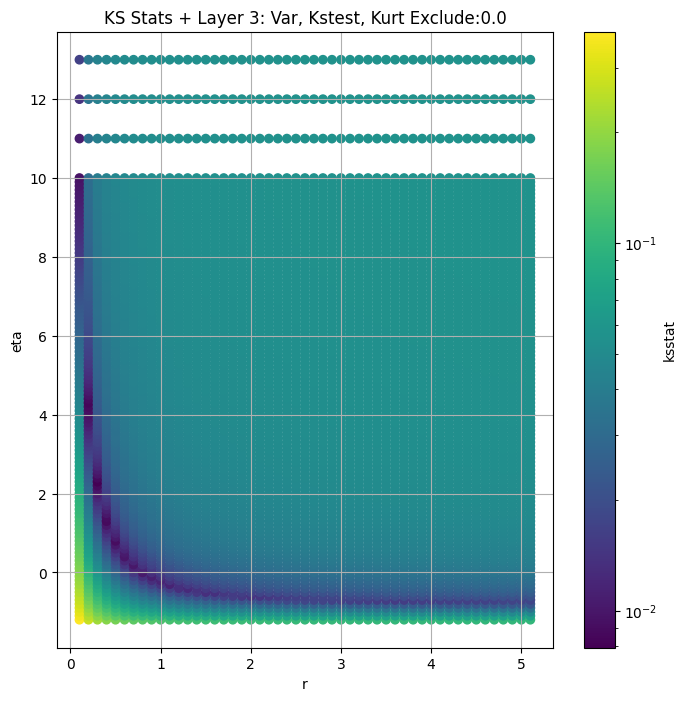

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.0030629045128119925 75.477356


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.0034103620170268245 71.727135


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.0046316979585904194 69.19353


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.005829222752984364 67.08207


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.006859949517985367 65.278366


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.008869448971981324 62.285427


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.011057597032127407 59.765835


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.013176925318852048 57.55742


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.015114160375736083 55.545753


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.017008677835039232 53.696842


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.023464759730357665 48.92552
Number of samples: 25440, Without approximation : 25440


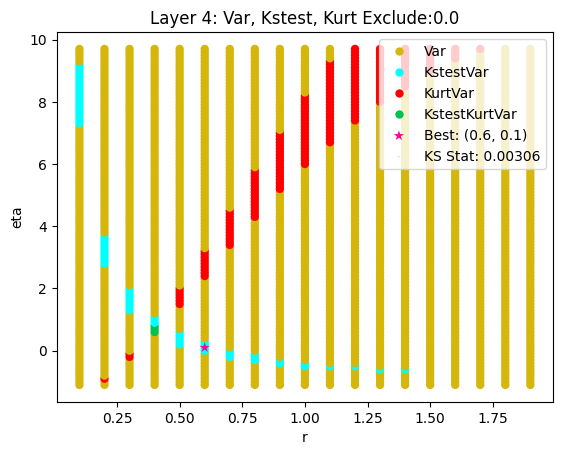

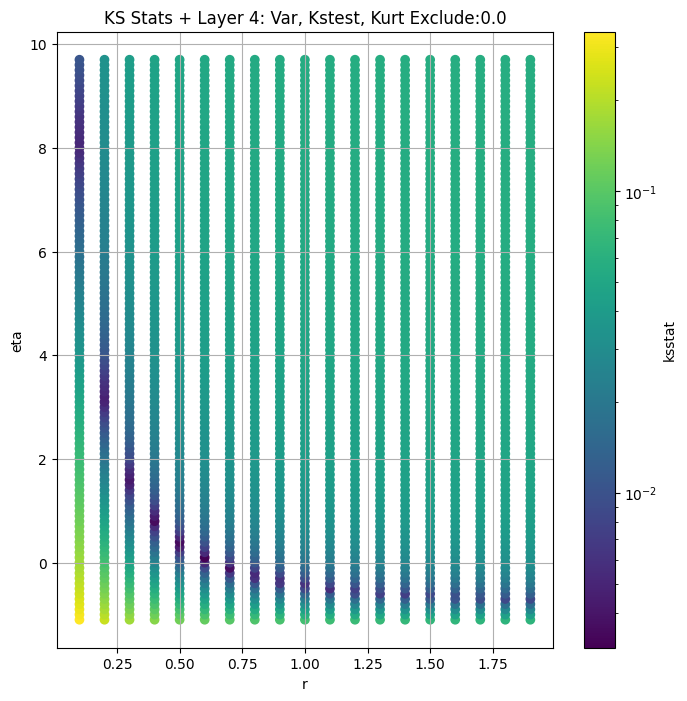

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.0016064024309042635 14.740032


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.0018009129818187253 14.436079


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.002680342603601976 14.225165


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.0031708561042768646 14.044789


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.00348205914968136 13.882556


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.0038115318003298926 13.5970955


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.0044040436230147195 13.349264


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.005046107737708305 13.124011


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.005692176270555627 12.914814


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.006294049757585185 12.720017


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.007884183077716489 12.198795
Number of samples: 100000, Without approximation : 101760


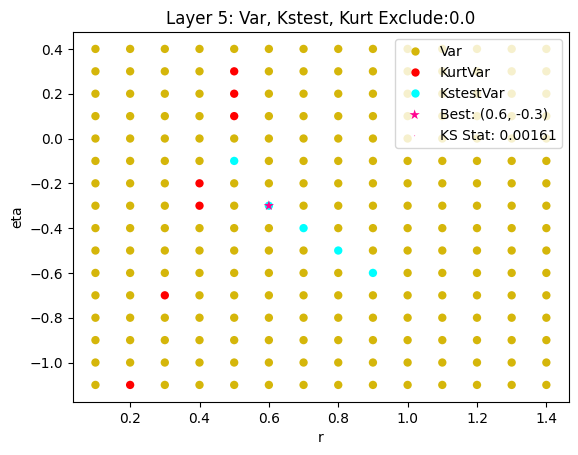

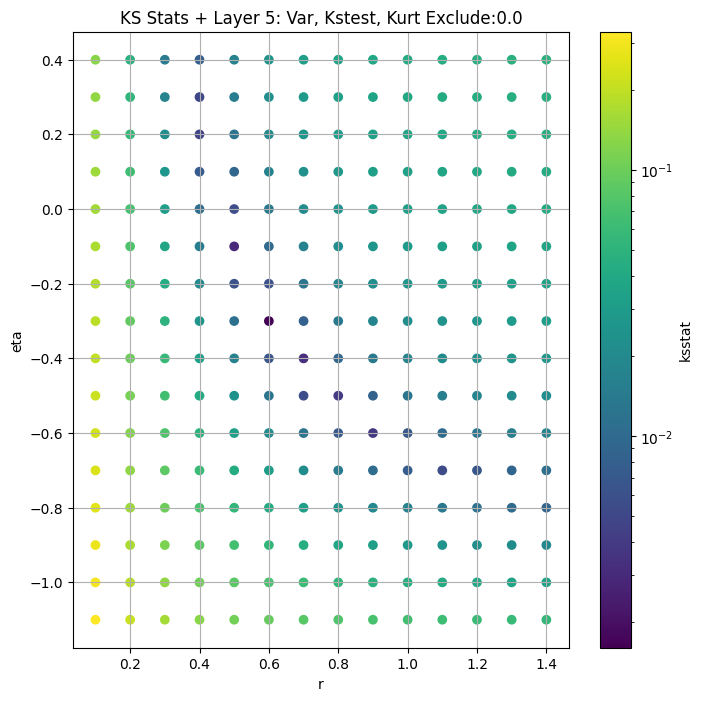

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.0050551540700006226 2.6784303


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.005407861607807096 2.6087542


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.004994725864440275 2.563191


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.0052512065033619715 2.525105


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.005664526634061917 2.4913929


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.005844581639444124 2.4319992


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.006260086836566092 2.3800678


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.006190374713243907 2.33327


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.006712792831108205 2.2906265


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.007075438703331549 2.2513793


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.008887083524797279 2.1477585
Number of samples: 100000, Without approximation : 407040


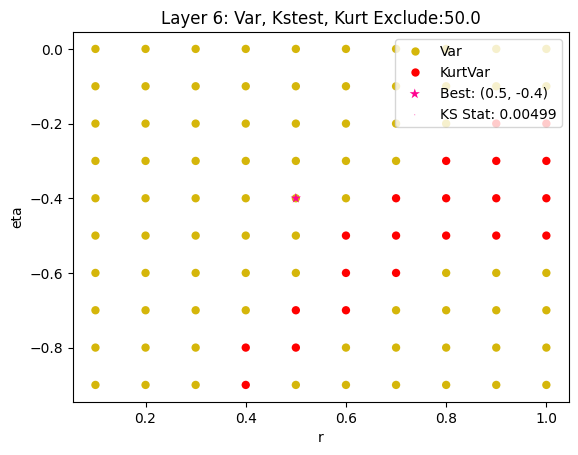

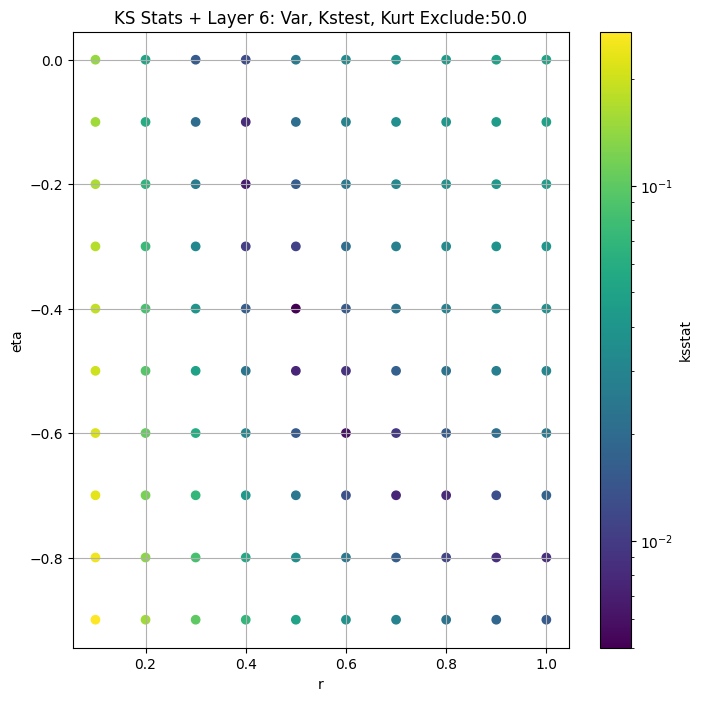

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.006099054257995173 0.47023675


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.005691450136990683 0.4537636


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.0062435255629477715 0.44363597


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.0067667502399964 0.43528378


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.00733321999520492 0.42800814


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.007073695924251444 0.41542223


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.0072210788564816 0.40462998


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.0072686759414187785 0.3950716


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.008295247648381743 0.38641483


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.008989436703562559 0.37848502


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.010056507765271672 0.35770822
Number of samples: 100000, Without approximation : 1628160


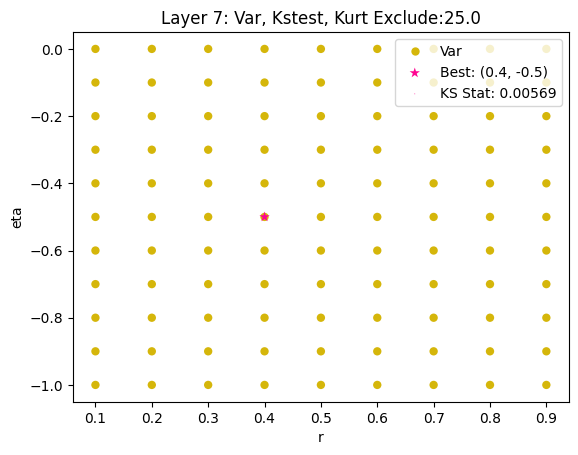

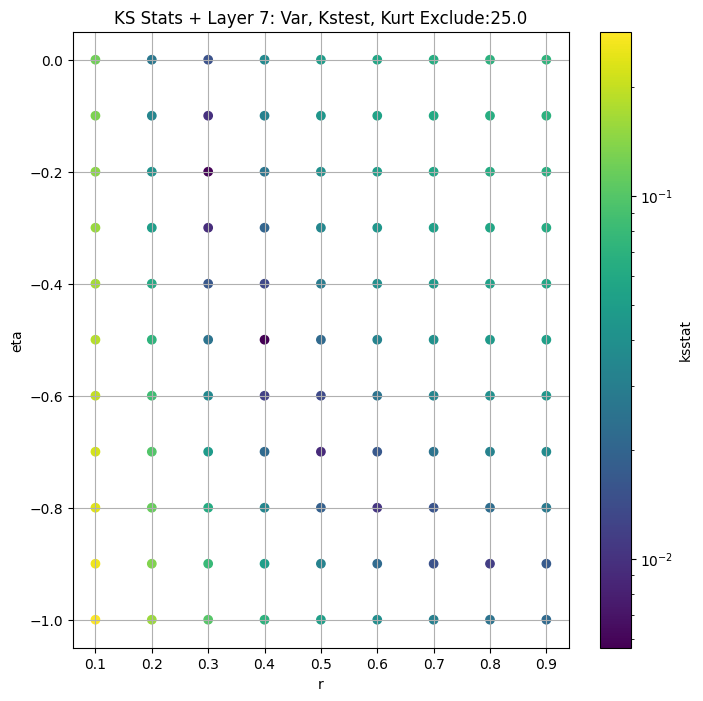

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.004025318880005735 0.05227801


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.004180178691236991 0.04937165


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.004899342196553524 0.04803118


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.0042595404009994065 0.046964202


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.005123102926979817 0.046051405


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.005046648358103645 0.044509936


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.006262175200969611 0.04321323


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.0063082684053319404 0.04207966


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.0071948388373906935 0.041066192


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.007485424202622881 0.040145922


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.008982674638354726 0.03778072
Number of samples: 100000, Without approximation : 6512640


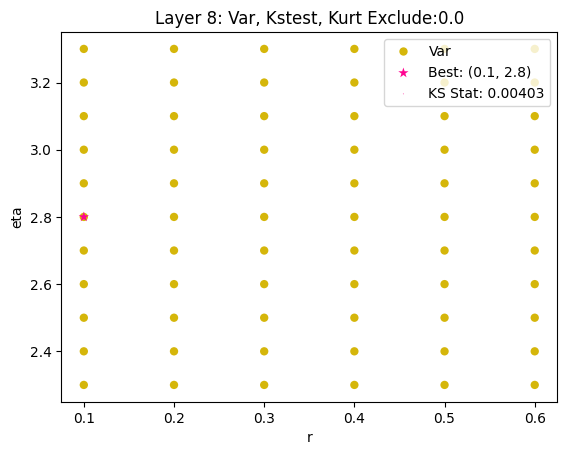

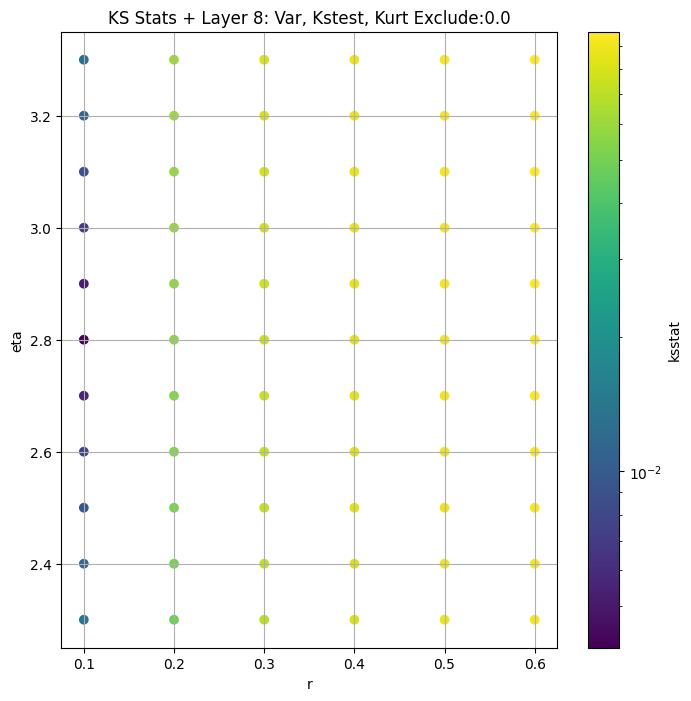

obs_var   var_lower    var_upper   obs_kurt  kurt_lower  kurt_upper  \
layer                                                                           
2      990.116330  861.928960  1131.759600   2.443838    1.024734    4.018030   
3      301.279600  280.958000   322.557980   2.566934    1.891120    3.315567   
4       75.477356   71.196570    79.962980   3.069100    2.393951    4.079803   
5       14.740032   13.840556    15.680383   3.907264    3.033695    5.042107   
6        2.678430    2.496106     2.874468   5.563306    4.164392    8.168119   
7        0.470237    0.432168     0.512633   8.734539    6.109381   15.380407   
8        0.052278    0.047054     0.060721  21.203135    7.482663  102.776710   

       total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                               
2               1590             0.012203        1.6         -0.3   
3               6360             0.007931        0.3          2.3   
4              25440             0.003063        0.6          0.1   
5             101760             0.001606        0.6         -0.3   
6             407040             0.004995        0.5         -0.4   
7            1628160             0.005691        0.4         -0.5   
8            6512640             0.004025        0.1          2.8   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       1.364930e+03                     0.0          990.116330   
3       4.776155e-02                     0.0          301.279600   
4       1.226295e+01                     0.0           75.477356   
5       3.673802e+00                     0.0           14.740032   
6       3.640896e-01                    50.0            2.563191   
7       2.513360e-02                    25.0            0.453764   
8       9.106445e-19                     0.0            0.052278   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.033952  
3                     0.017003  
4                     0.008508  
5                     0.004256  
6                     0.002128  
7                     0.001064  
8                     0.000532

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/1458 [00:00<?, ?it/s]

Finding Minimum after computing 1458 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.08721926098896438, var: 431.44317626953125


  0%|          | 0/1458 [00:00<?, ?it/s]

Finding Minimum after computing 1458 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.07180854698096639, var: 502.1907043457031


  0%|          | 0/1458 [00:00<?, ?it/s]

Finding Minimum after computing 1458 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.05480784742339817, var: 591.125


  0%|          | 0/1458 [00:00<?, ?it/s]

Finding Minimum after computing 1458 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.03459450622158877, var: 715.2362060546875


  0%|          | 0/1458 [00:00<?, ?it/s]

Finding Minimum after computing 1458 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.011869429359457784, var: 990.1163330078125
Number of samples: 1590, Without approximation : 1590


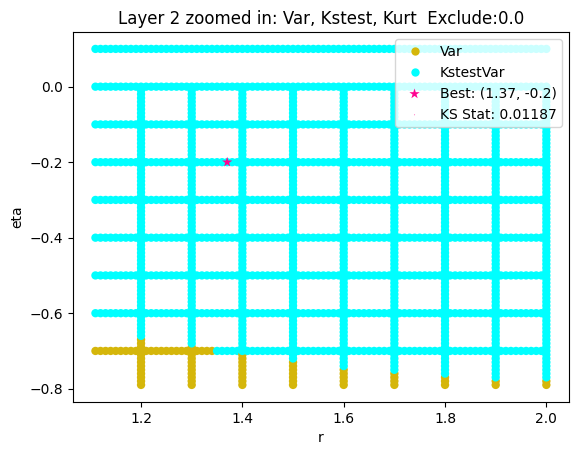

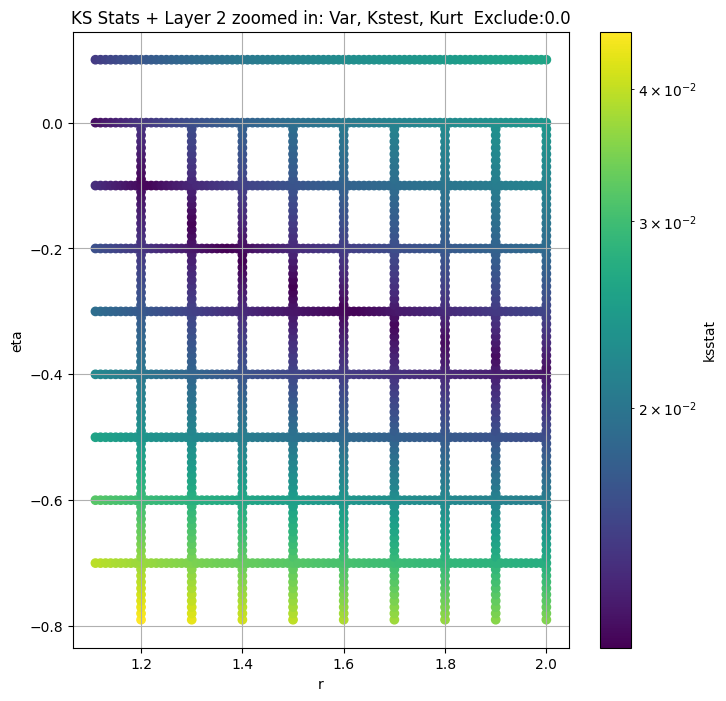

Layer 3


  0%|          | 0/780 [00:00<?, ?it/s]

Finding Minimum after computing 780 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.02697022198145159, var: 213.564453125


  0%|          | 0/780 [00:00<?, ?it/s]

Finding Minimum after computing 780 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.02169272825330451, var: 226.72850036621094


  0%|          | 0/780 [00:00<?, ?it/s]

Finding Minimum after computing 780 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.01638808786984483, var: 242.00303649902344


  0%|          | 0/780 [00:00<?, ?it/s]

Finding Minimum after computing 780 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.012698676337318263, var: 262.677734375


  0%|          | 0/780 [00:00<?, ?it/s]

Finding Minimum after computing 780 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.007931352457062446, var: 301.27960205078125
Number of samples: 6360, Without approximation : 6360


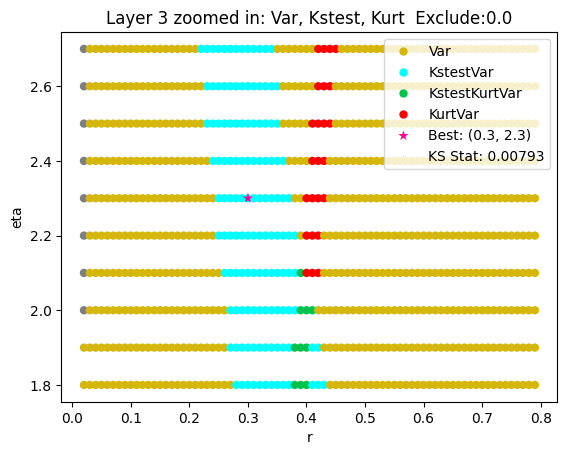

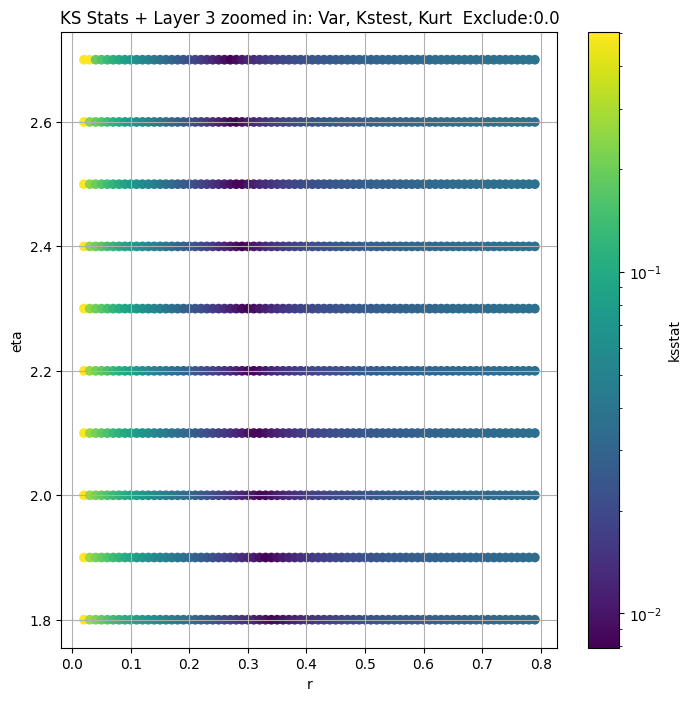

Layer 4


  0%|          | 0/1215 [00:00<?, ?it/s]

Finding Minimum after computing 1215 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.0075211373902415585, var: 65.27836608886719


  0%|          | 0/1215 [00:00<?, ?it/s]

Finding Minimum after computing 1215 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.006037388845647661, var: 67.08206939697266


  0%|          | 0/1215 [00:00<?, ?it/s]

Finding Minimum after computing 1215 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.0046316979585904194, var: 69.19352722167969


  0%|          | 0/1215 [00:00<?, ?it/s]

Finding Minimum after computing 1215 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.003362273492403256, var: 71.72713470458984


  0%|          | 0/1215 [00:00<?, ?it/s]

Finding Minimum after computing 1215 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.002828490200588507, var: 75.47735595703125
Number of samples: 25440, Without approximation : 25440


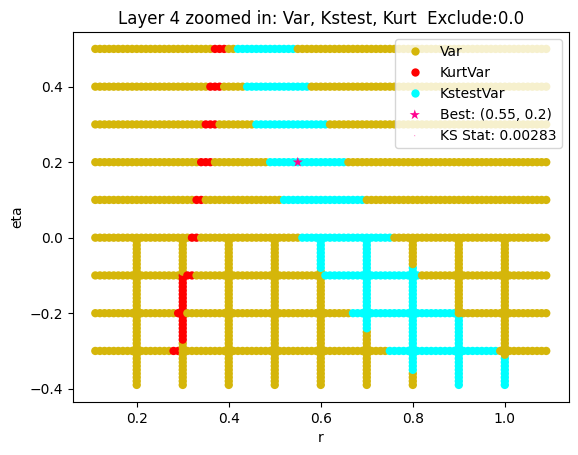

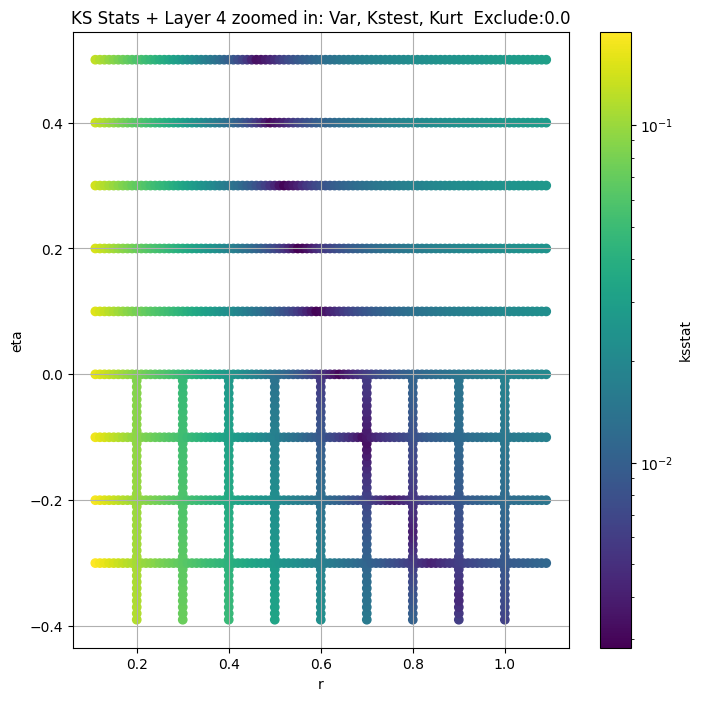

Layer 5


  0%|          | 0/1539 [00:00<?, ?it/s]

Finding Minimum after computing 1539 CDFs
layer 5, 0.0 + 100 = 100, ksstat: 0.0029775893471740145, var: 13.882555961608887


  0%|          | 0/1539 [00:00<?, ?it/s]

Finding Minimum after computing 1539 CDFs
layer 5, 0.0 + 75 = 75, ksstat: 0.0026036932833500837, var: 14.04478931427002


  0%|          | 0/1539 [00:00<?, ?it/s]

Finding Minimum after computing 1539 CDFs
layer 5, 0.0 + 50 = 50, ksstat: 0.002220991318568122, var: 14.225165367126465


  0%|          | 0/1539 [00:00<?, ?it/s]

Finding Minimum after computing 1539 CDFs
layer 5, 0.0 + 25 = 25, ksstat: 0.0018009129818187253, var: 14.436079025268555


  0%|          | 0/1539 [00:00<?, ?it/s]

Finding Minimum after computing 1539 CDFs
layer 5, 0.0 + 0 = 0, ksstat: 0.0016064024309042635, var: 14.740032196044922
Number of samples: 100000, Without approximation : 101760


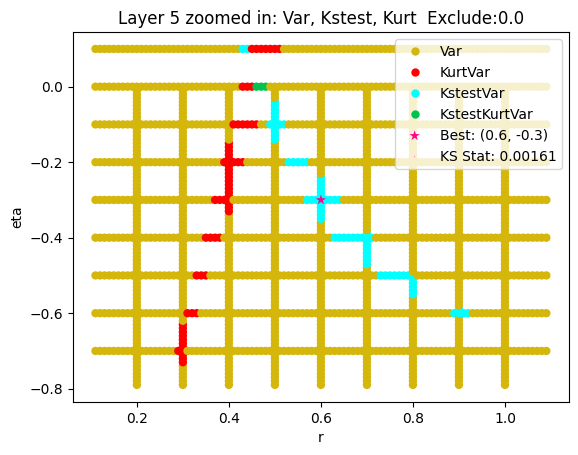

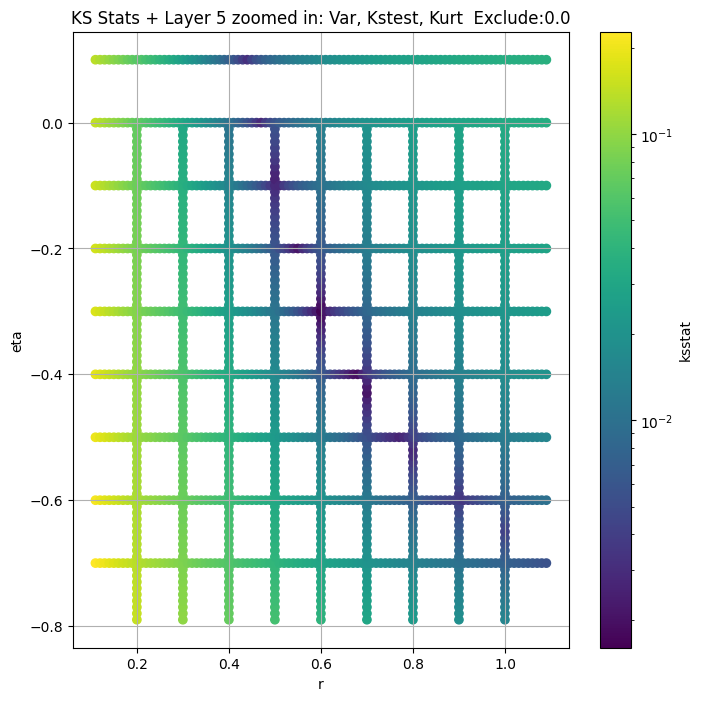

Layer 6


  0%|          | 0/1611 [00:00<?, ?it/s]

Finding Minimum after computing 1611 CDFs
layer 6, 50.0 + 100 = 150, ksstat: 0.005219484216430037, var: 2.4319992065429688


  0%|          | 0/1611 [00:00<?, ?it/s]

Finding Minimum after computing 1611 CDFs
layer 6, 50.0 + 75 = 125, ksstat: 0.004886386218126371, var: 2.460674285888672


  0%|          | 0/1611 [00:00<?, ?it/s]

Finding Minimum after computing 1611 CDFs
layer 6, 50.0 + 50 = 100, ksstat: 0.004567763060745522, var: 2.4913928508758545


  0%|          | 0/1611 [00:00<?, ?it/s]

Finding Minimum after computing 1611 CDFs
layer 6, 50.0 + 25 = 75, ksstat: 0.004321037376978254, var: 2.5251049995422363


  0%|          | 0/1611 [00:00<?, ?it/s]

Finding Minimum after computing 1611 CDFs
layer 6, 50.0 + 0 = 50, ksstat: 0.004118881656068496, var: 2.5631909370422363


  0%|          | 0/1611 [00:00<?, ?it/s]

Finding Minimum after computing 1611 CDFs
layer 6, 50.0 + -25 = 25, ksstat: 0.003945397921935878, var: 2.6087541580200195


  0%|          | 0/1611 [00:00<?, ?it/s]

Finding Minimum after computing 1611 CDFs
layer 6, 50.0 + -50 = 0, ksstat: 0.004069527237210269, var: 2.6784303188323975
Number of samples: 100000, Without approximation : 407040


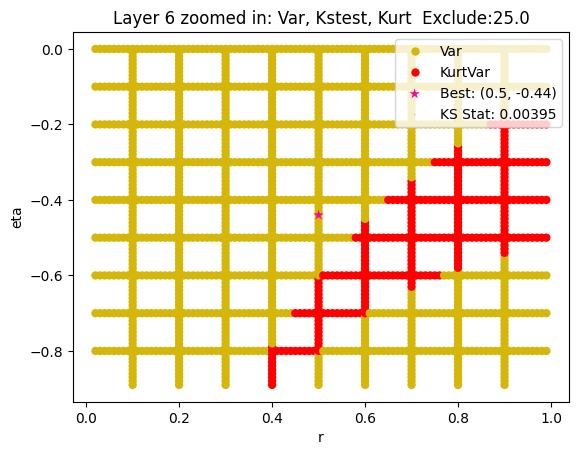

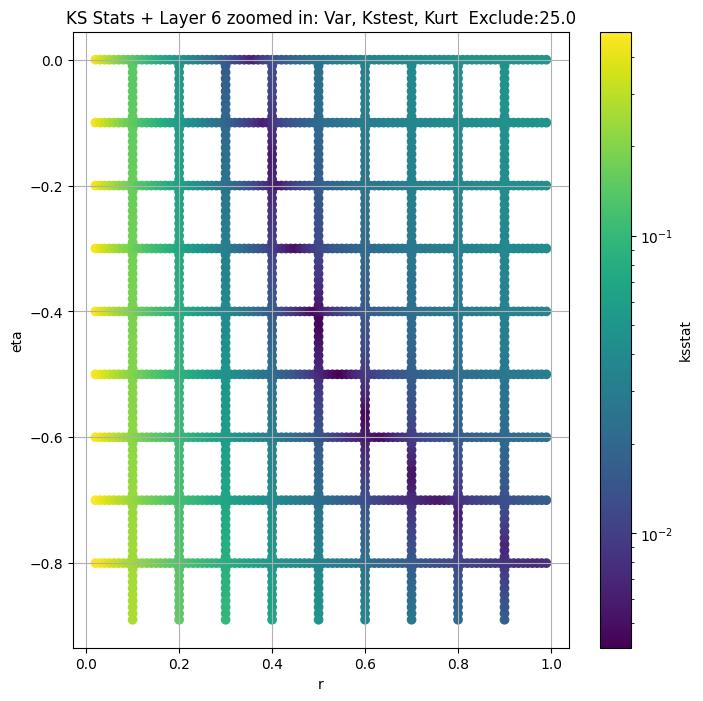

Layer 7


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 7, 25.0 + 100 = 125, ksstat: 0.0061949719432493056, var: 0.4214417338371277


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 7, 25.0 + 75 = 100, ksstat: 0.005858594313712717, var: 0.42800813913345337


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 7, 25.0 + 50 = 75, ksstat: 0.005466177989354226, var: 0.4352837800979614


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 7, 25.0 + 25 = 50, ksstat: 0.00549811196537453, var: 0.4436359703540802


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 7, 25.0 + 0 = 25, ksstat: 0.004912800108248239, var: 0.45376360416412354


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 7, 25.0 + -25 = 0, ksstat: 0.0047347228261184204, var: 0.47023674845695496
Number of samples: 100000, Without approximation : 1628160


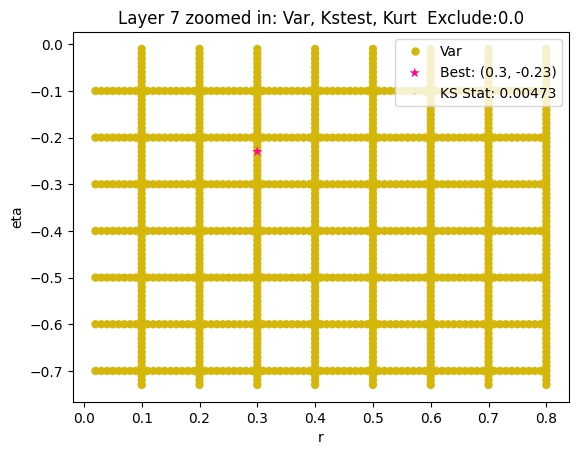

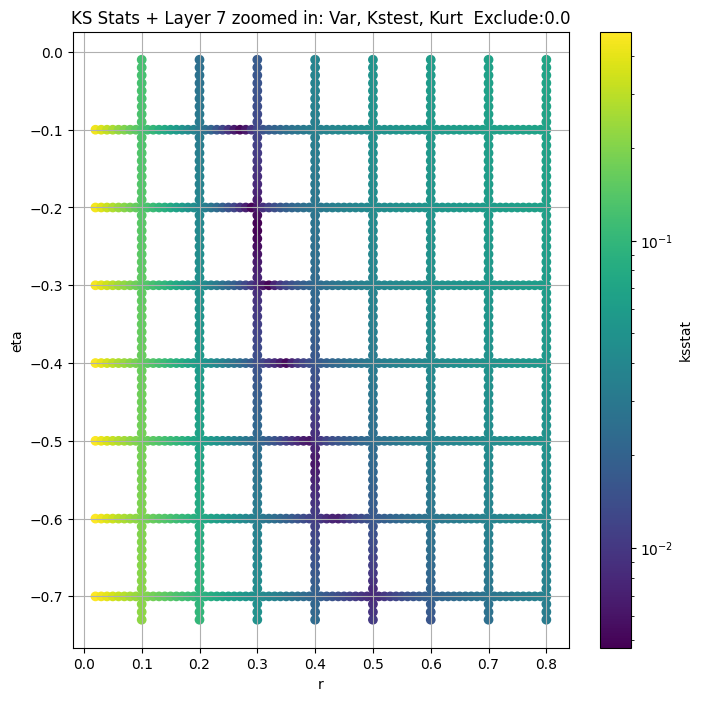

Layer 8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 0.0 + 100 = 100, ksstat: 0.005794512210724578, var: 0.04605140537023544


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 0.0 + 75 = 75, ksstat: 0.005202145300846173, var: 0.04696420207619667


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 0.0 + 50 = 50, ksstat: 0.0044989189965123355, var: 0.04803118109703064


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 0.0 + 25 = 25, ksstat: 0.003998357919340778, var: 0.04937164857983589


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 0.0 + 0 = 0, ksstat: 0.004025318880005735, var: 0.05227800831198692
Number of samples: 100000, Without approximation : 6512640


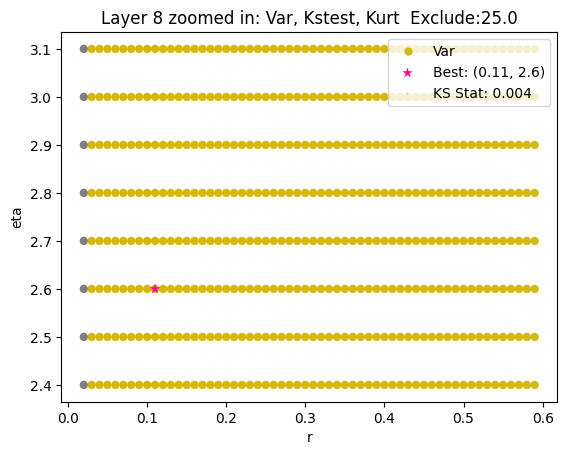

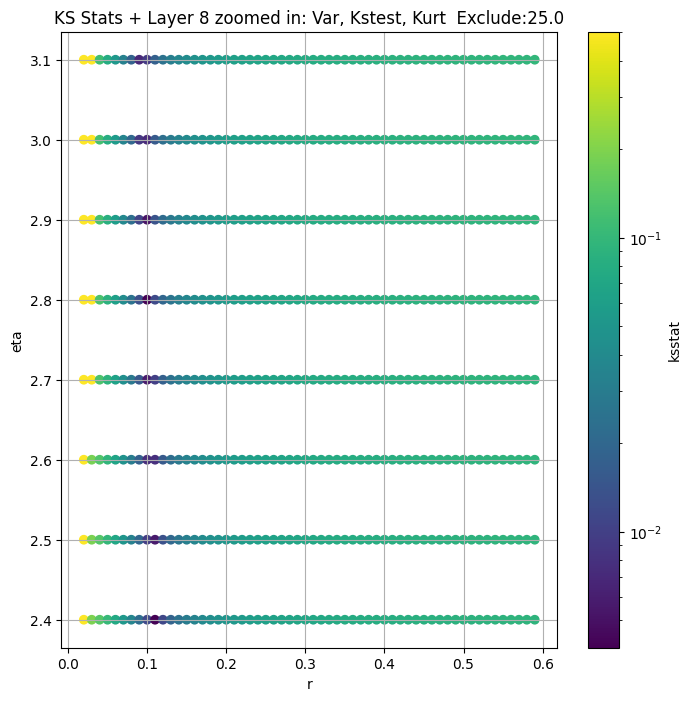

obs_var   var_lower    var_upper   obs_kurt  kurt_lower  kurt_upper  \
layer                                                                           
2      990.116330  861.928960  1131.759600   2.443838    1.024734    4.018030   
3      301.279600  280.958000   322.557980   2.566934    1.891120    3.315567   
4       75.477356   71.196570    79.962980   3.069100    2.393951    4.079803   
5       14.740032   13.840556    15.680383   3.907264    3.033695    5.042107   
6        2.678430    2.496106     2.874468   5.563306    4.164392    8.168119   
7        0.470237    0.432168     0.512633   8.734539    6.109381   15.380407   
8        0.052278    0.047054     0.060721  21.203135    7.482663  102.776710   

       total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                               
2               1590             0.012203        1.6         -0.3   
3               6360             0.007931        0.3          2.3   
4              25440             0.003063        0.6          0.1   
5             101760             0.001606        0.6         -0.3   
6             407040             0.004995        0.5         -0.4   
7            1628160             0.005691        0.4         -0.5   
8            6512640             0.004025        0.1          2.8   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       1.364930e+03                     0.0          990.116333   
3       4.776155e-02                     0.0          301.279600   
4       1.226295e+01                     0.0           75.477356   
5       3.673802e+00                     0.0           14.740032   
6       3.640896e-01                    50.0            2.608754   
7       2.513360e-02                    25.0            0.470237   
8       9.106445e-19                     0.0            0.049372   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.033952          0.011869    1.37     -0.20   
3                     0.017003          0.007931    0.30      2.30   
4                     0.008508          0.002828    0.55      0.20   
5                     0.004256          0.001606    0.60     -0.30   
6                     0.002128          0.003945    0.50     -0.44   
7                     0.001064          0.004735    0.30     -0.23   
8                     0.000532          0.003998    0.11      2.60   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      1.129535e+03                  0.0        13578  
3      4.776155e-02                  0.0        30559  
4      7.849325e+00                  0.0       232078  
5      3.673802e+00                  0.0       733498  
6      3.944053e-01                 25.0       114480  
7      1.788162e-03                  0.0        85860  
8      1.021363e-16                 25.0       114480

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

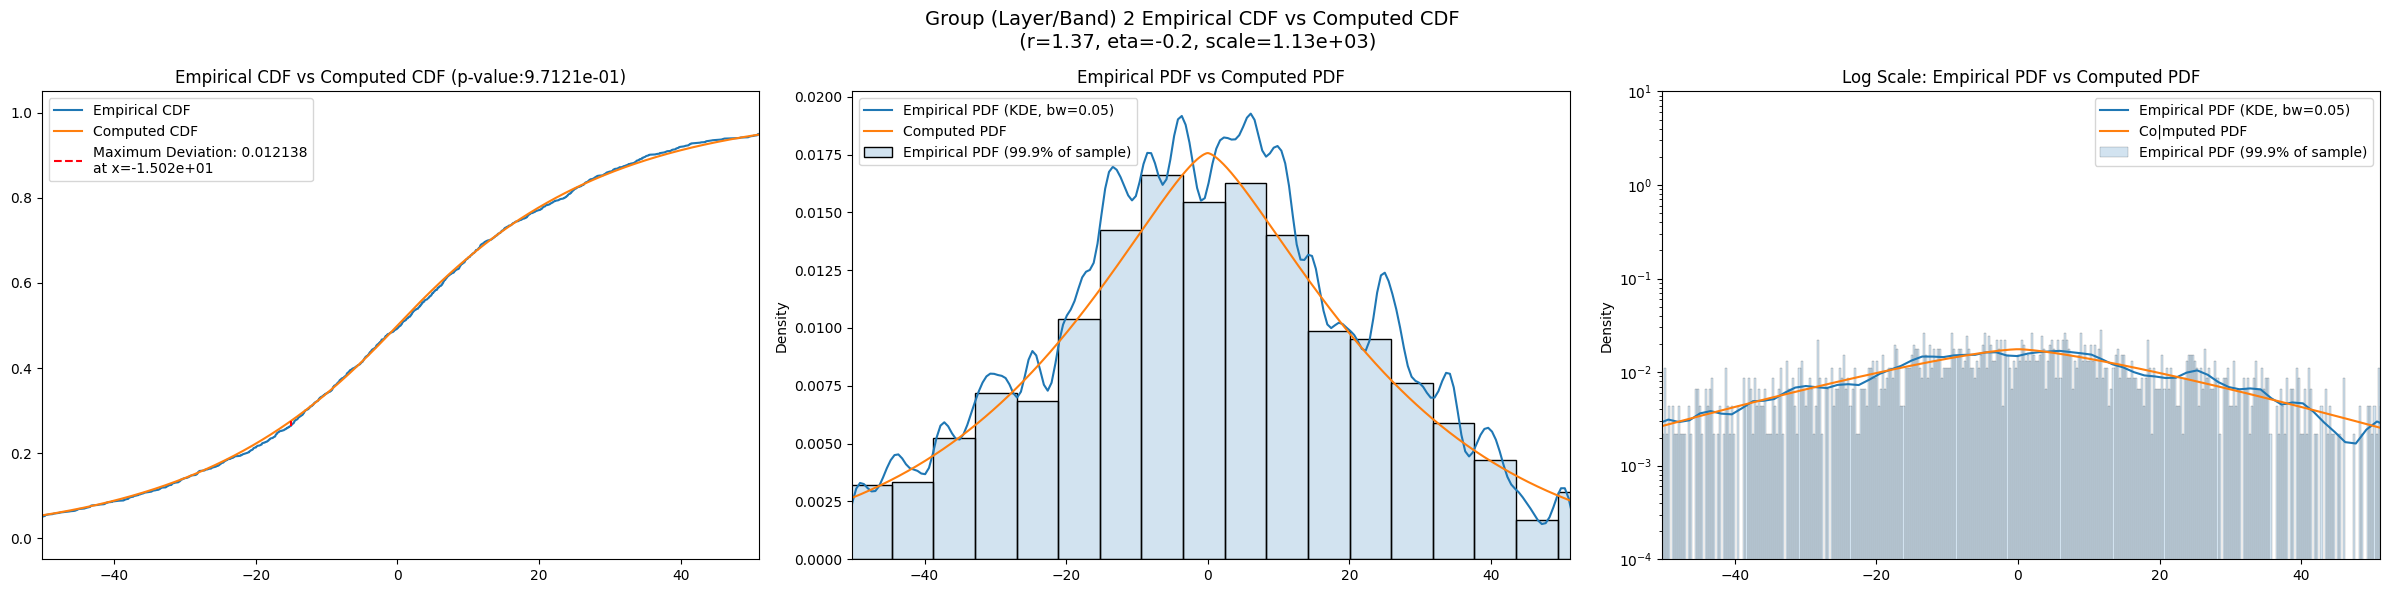

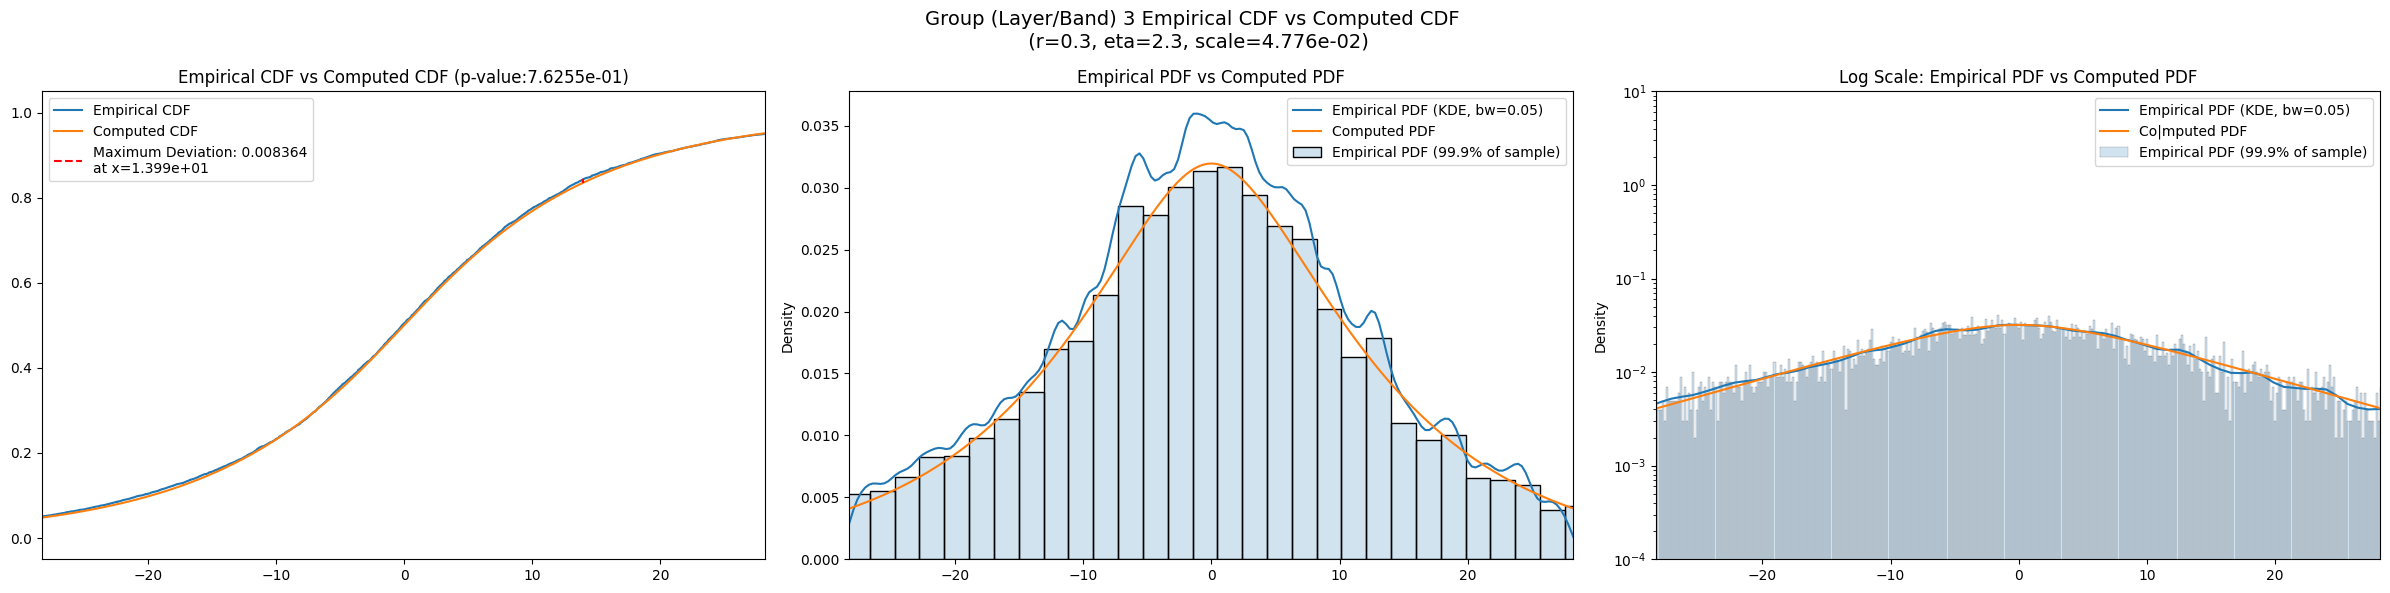

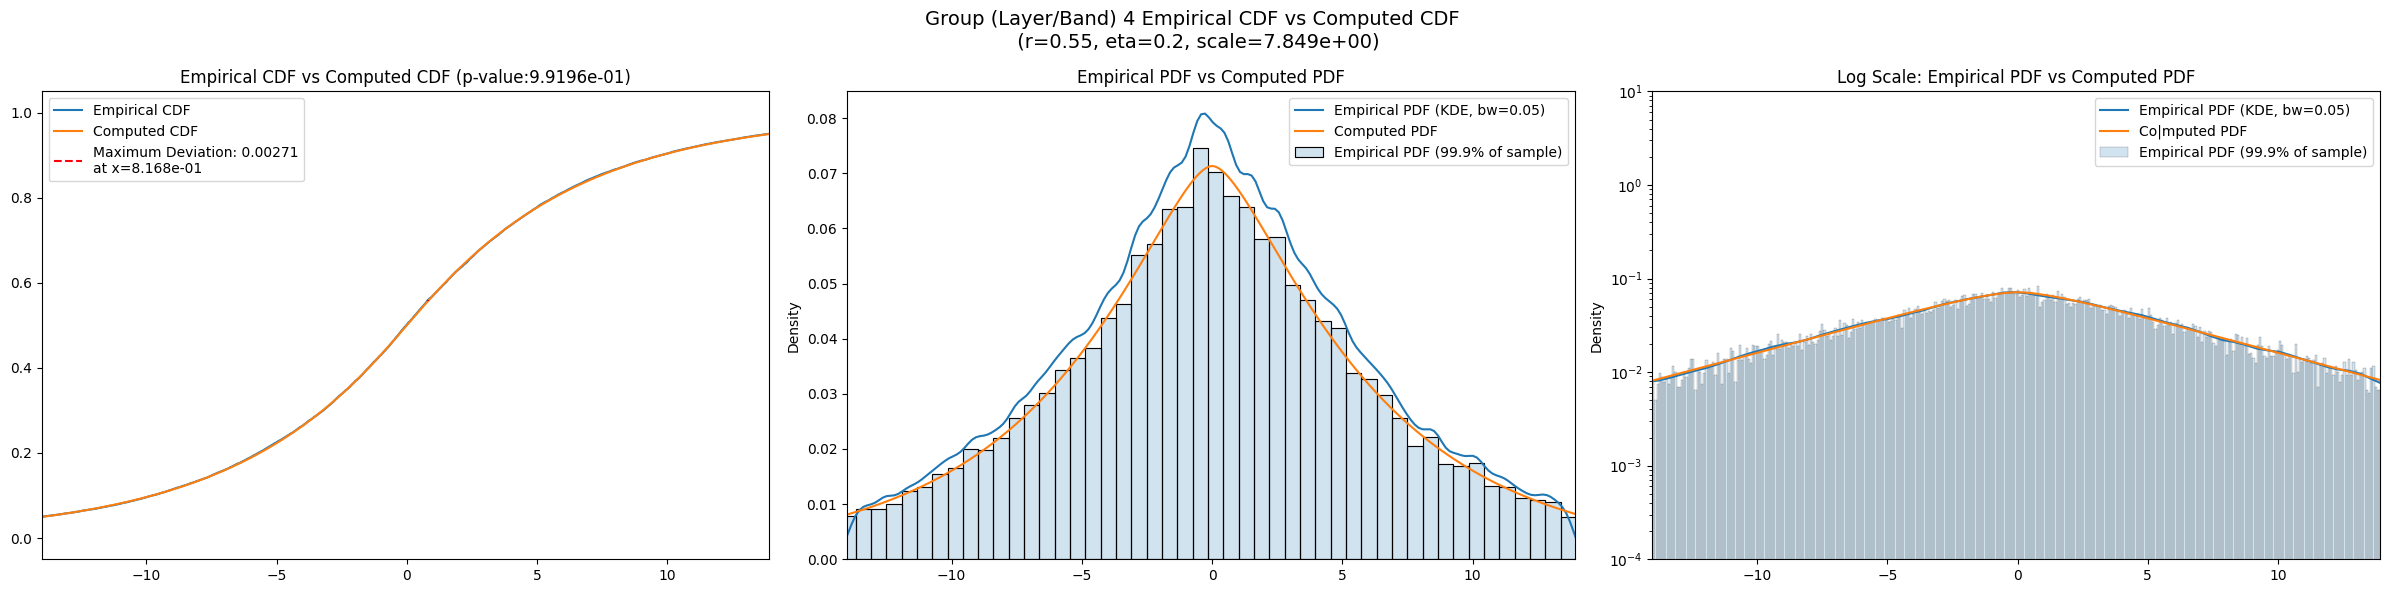

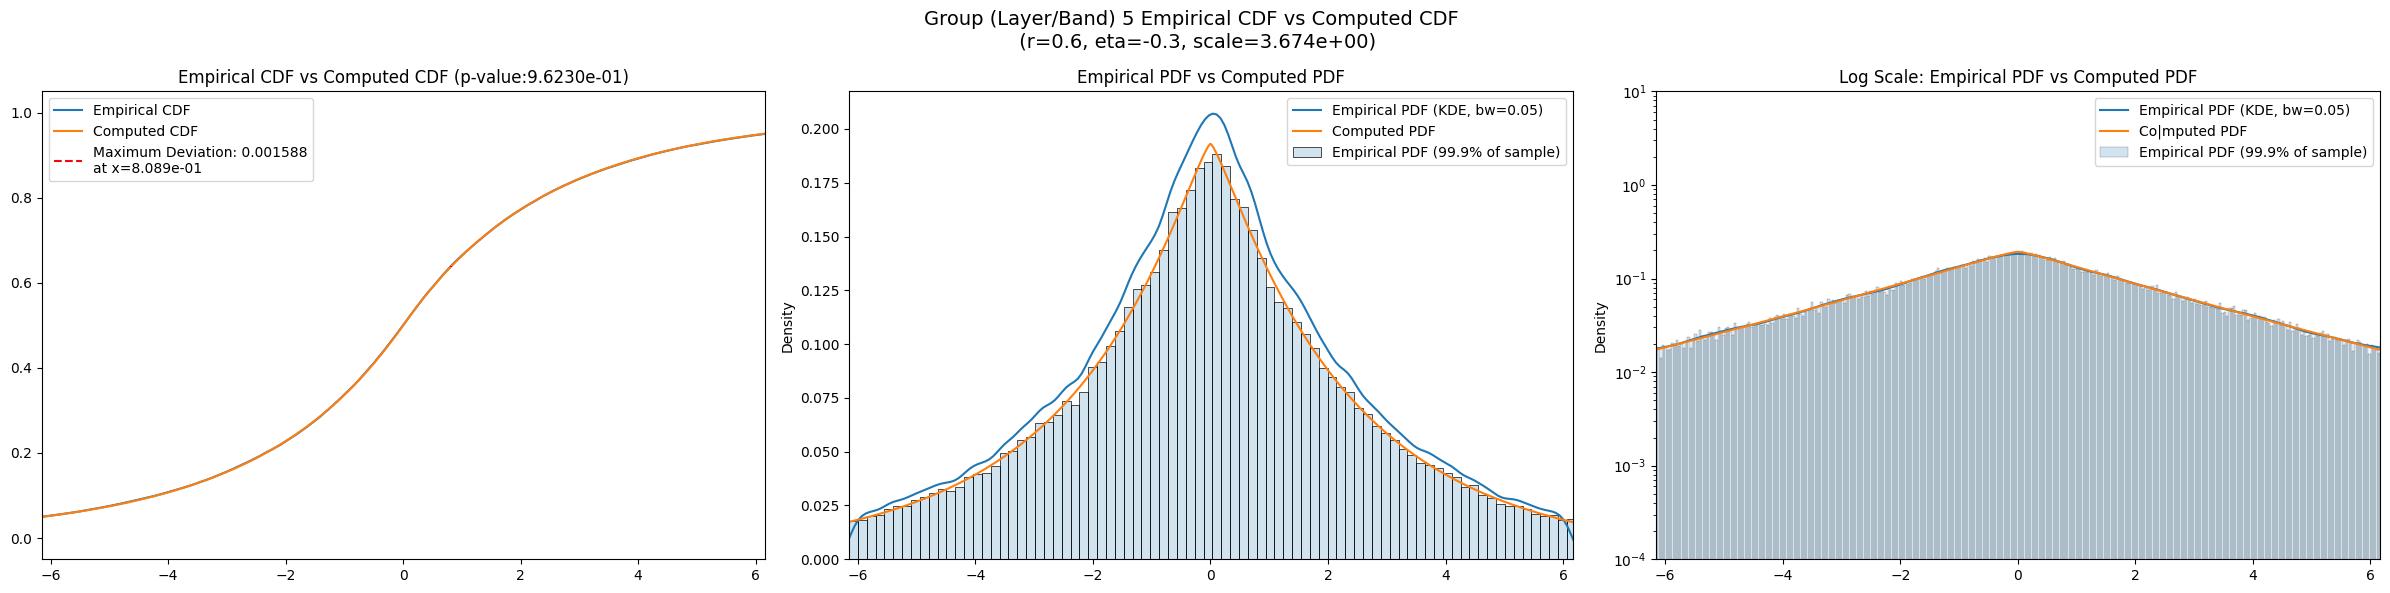

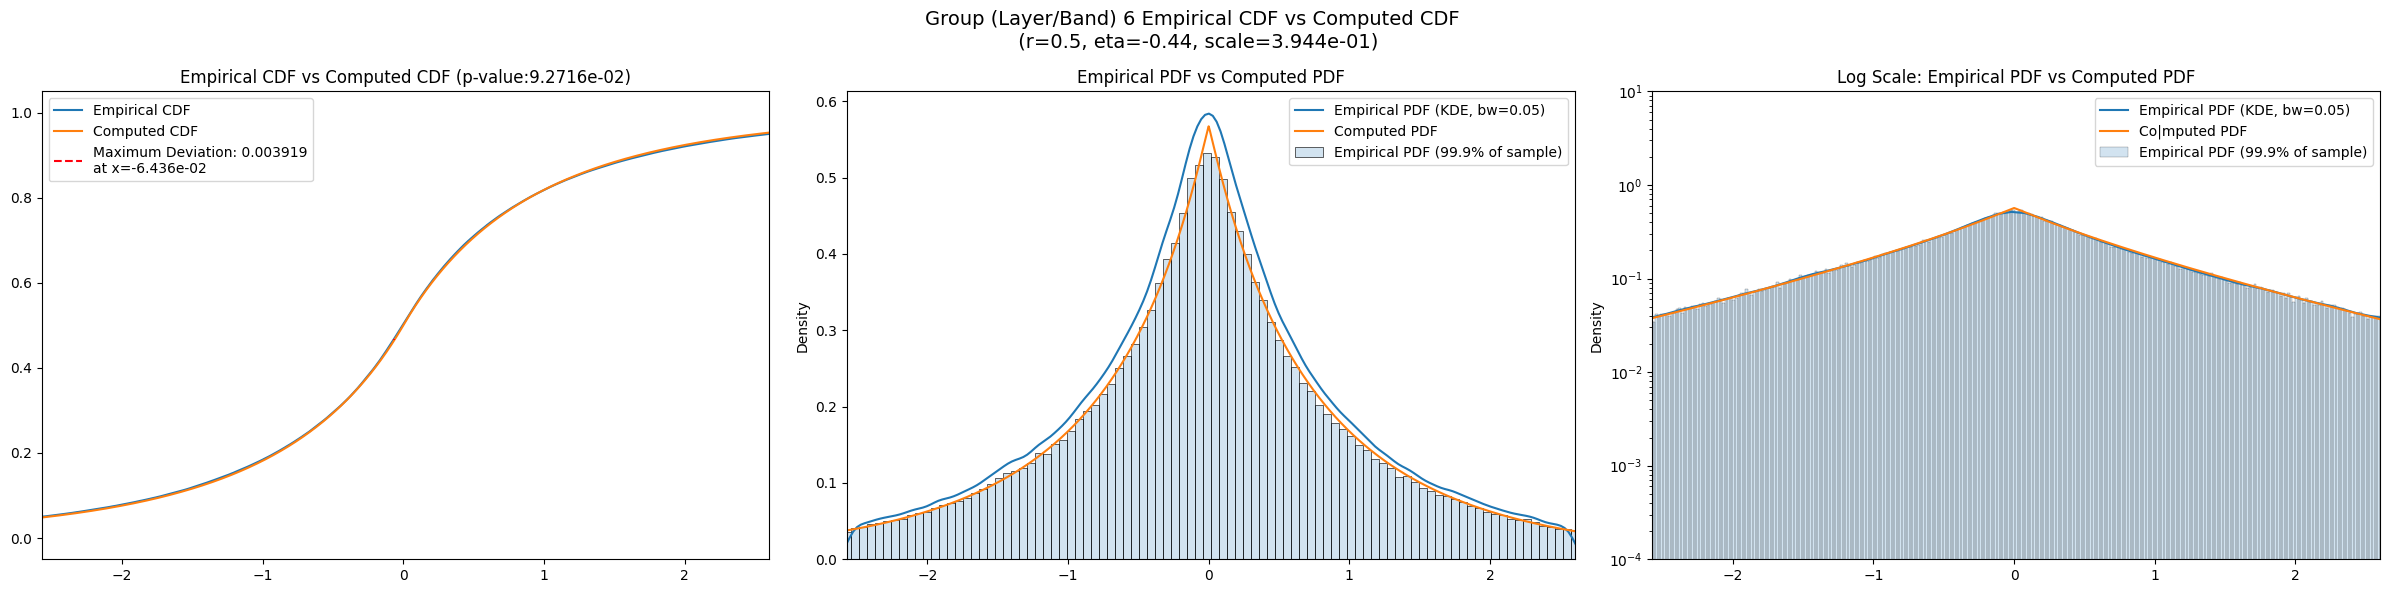

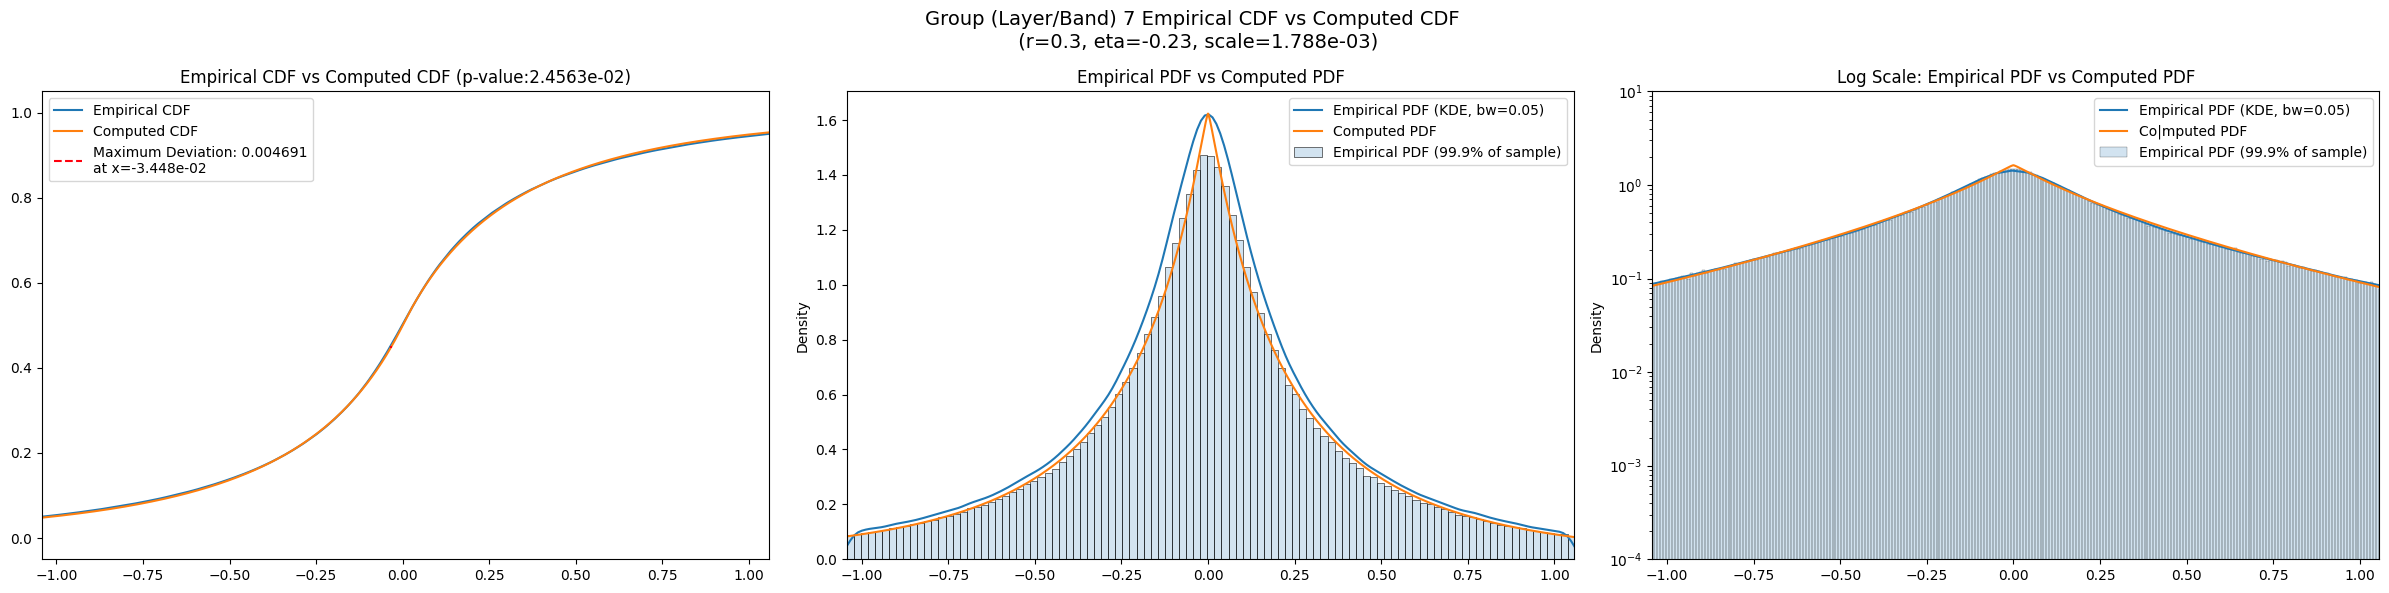

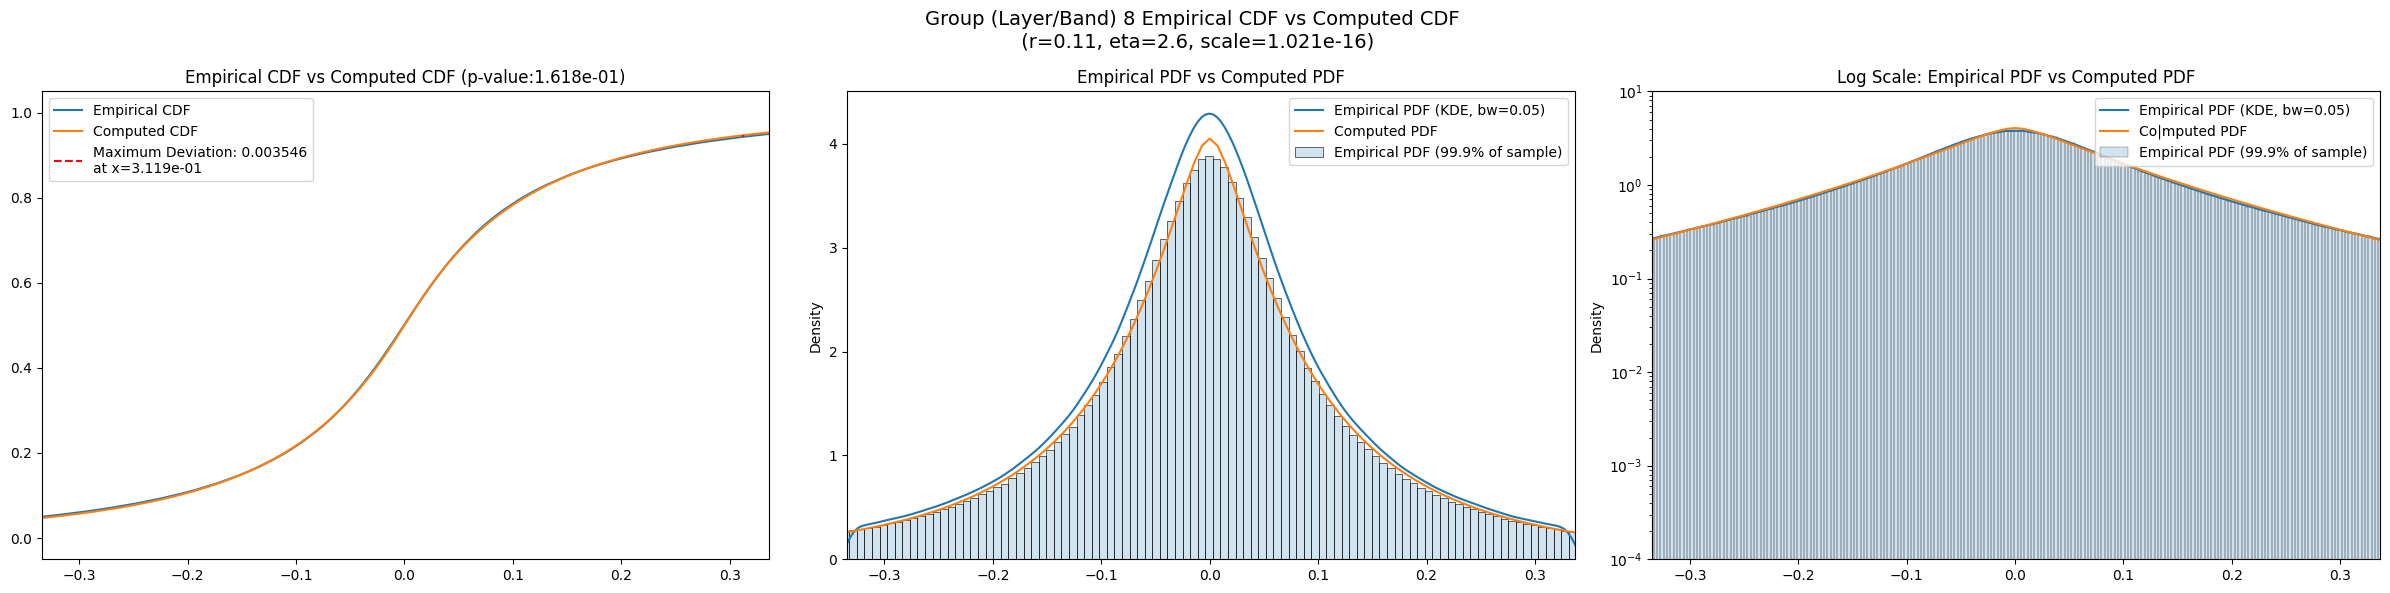

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var   var_lower    var_upper   obs_kurt  kurt_lower  kurt_upper  \
layer                                                                           
2      990.116330  861.928960  1131.759600   2.443838    1.024734    4.018030   
3      301.279600  280.958000   322.557980   2.566934    1.891120    3.315567   
4       75.477356   71.196570    79.962980   3.069100    2.393951    4.079803   
5       14.740032   13.840556    15.680383   3.907264    3.033695    5.042107   
6        2.678430    2.496106     2.874468   5.563306    4.164392    8.168119   
7        0.470237    0.432168     0.512633   8.734539    6.109381   15.380407   
8        0.052278    0.047054     0.060721  21.203135    7.482663  102.776710   

       total_samples  kstest_stat_initial  initial_r  initial_eta  ...  \
layer                                                              ...   
2               1590             0.012203        1.6         -0.3  ...   
3               6360             0.007931        0.3          2.3  ...   
4              25440             0.003063        0.6          0.1  ...   
5             101760             0.001606        0.6         -0.3  ...   
6             407040             0.004995        0.5         -0.4  ...   
7            1628160             0.005691        0.4         -0.5  ...   
8            6512640             0.004025        0.1          2.8  ...   

       param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer                                                               
2           27.076900              0.025445          2.503870e-01   
3           14.599400              0.025768          4.218180e-04   
4            7.116070              0.026167          1.450830e-15   
5            2.964220              0.032139          9.456690e-92   
6            1.141290              0.041581          0.000000e+00   
7            0.427636              0.048413          0.000000e+00   
8            0.145058              0.041903          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          24.492200             0.018843         6.179030e-01  20.018200   
3          13.099900             0.015206         1.045170e-01  10.518900   
4           6.250340             0.006271         2.686580e-01   5.076580   
5           2.591260             0.004569         2.845690e-02   2.134440   
6           0.999364             0.013611         6.195280e-66   0.812873   
7           0.375367             0.020745         0.000000e+00   0.301573   
8           0.127251             0.015246         0.000000e+00   0.102928   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.021633   4.402080e-01          9.766014e-01  
3           0.015355   9.863850e-02          8.154378e-01  
4           0.011630   2.036530e-03          9.867148e-01  
5           0.009167   7.426970e-08          9.550445e-01  
6           0.016777  5.918510e-100          6.258166e-06  
7           0.021410   0.000000e+00          3.950466e-32  
8           0.012961   0.000000e+00          7.332514e-91  

[7 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.012203                 0.033952          0.011869   
3                 0.007931                 0.017003          0.007931   
4                 0.003063                 0.008508          0.002828   
5                 0.001606                 0.004256          0.001606   
6                 0.004995                 0.002128          0.003945   
7                 0.005691                 0.001064          0.004735   
8                 0.004025                 0.000532          0.003998   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.025445             0.018843       0.021633  
3                  0.025768             0.015206       0.015355  
4                  0.026167             0.006271       0.011630  
5                  0.032139             0.004569       0.009167  
6                  0.041581             0.013611       0.016777  
7                  0.048413             0.020745       0.021410  
8                  0.041903             0.015246       0.012961

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2              990.116333          0.011869    1.37     -0.20  1.129535e+03   
3              301.279600          0.007931    0.30      2.30  4.776155e-02   
4               75.477356          0.002828    0.55      0.20  7.849325e+00   
5               14.740032          0.001606    0.60     -0.30  3.673802e+00   
6                2.608754          0.003945    0.50     -0.44  3.944053e-01   
7                0.470237          0.004735    0.30     -0.23  1.788162e-03   
8                0.049372          0.003998    0.11      2.60  1.021363e-16   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                      0.0  
5                      0.0  
6                     25.0  
7                      0.0  
8                     25.0

In [21]:
eng.quit()